<img style="max-width:20em; height:auto;" src="../graphics/A-Little-Book-on-Adversarial-AI-Cover.png"/>

Author: Nik Alleyne   
Author Blog: https://www.securitynik.com   
Author GitHub: github.com/securitynik   

Author Other Books: [   

            "https://www.amazon.ca/Learning-Practicing-Leveraging-Practical-Detection/dp/1731254458/",   
            
            "https://www.amazon.ca/Learning-Practicing-Mastering-Network-Forensics/dp/1775383024/"   
        ]   


This notebook ***(mal_net_tiny_malware_classification_multi_class.ipynb)*** is part of the series of notebooks From ***A Little Book on Adversarial AI***  A free ebook released by Nik Alleyne



Mal Image:  
    - https://github.com/safreita1/malnet-image   
    - https://www.mal-net.org/   
    - https://arxiv.org/pdf/2102.01072   

Additional Resources:  
Virus-MNIST: 
    - https://arxiv.org/pdf/2103.00602   
    - https://github.com/ayakimovich/virus-mnist    
Malimg:   
    - https://www.kaggle.com/datasets/manmandes/malimg   

Intel Whitepaper:   
    - Scalable Deep Learning Approach for Malware Classification   
    -  https://www.intel.com/content/dam/www/public/us/en/ai/documents/stamina-scalable-deep-learning-whitepaper.pdf   

### Malware Classification of MalNet Malware

### Lab Objectives:   
- Build a malware classifier for a multi-class problem   
- Work with mlflow  
- Understand model metrics   
- Saving and loading models  
- Make inferences to a remote API endpoint   

### Step 1:  
Get the data  

In [67]:
# Import our needed libraries 

import requests
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from zipfile import ZipFile
import io
from sklearn.preprocessing import LabelEncoder

In [68]:
### Version of key libraries used  
print(f'Torch version used:  {torch.__version__}')
print(f'Numpy version used:  {np.__version__}')

Torch version used:  2.7.1+cu128
Numpy version used:  2.1.3


In [69]:
# Setup the device to work with
# This should ensure if there are accelerators in place, such as Apple backend or CUDA, 
# we should be able to take advantage of it.

if torch.cuda.is_available():
    print('Setting the device to cuda')
    device = 'cuda'
elif torch.backends.mps.is_available():
    print('Setting the device to Apple mps')
    device = 'mps'
else:
    print('Setting the device to CPU')
    device = torch.device('cpu')

Setting the device to cuda


In [70]:
# Get the tiny malware dataset to work with
# Reference page:
# http://malnet.cc.gatech.edu/split-info/
url = 'http://malnet.cc.gatech.edu/split-info/split_info_tiny.zip'
url

'http://malnet.cc.gatech.edu/split-info/split_info_tiny.zip'

As a backup, this file is also inside of the data folder. If for some strange reason above does not work, perform the following:   
1. open a Linux command prompt and run **python3 -m http.server 9998***  
2. Change the url above to **http://127.0.0.1:9998/split_info_tiny.zip**   

Everything else should run as expected 

In [71]:
# Download the file
split_info_tiny_zip = requests.get(url=url)

# A response of 200, suggests everything is good to go
split_info_tiny_zip

<Response [200]>

In [72]:
# The PK shows that we have a a zip file
# We could have instead write this file to disk and read it back
# This will require a bit more work
# Let's instead try to keep as much content in memory
split_info_tiny_zip.content

b'PK\x03\x04\x14\x00\x00\x00\x00\x00Kb?R\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x10\x00 \x00split_info_tiny/UT\r\x00\x07\x8f\x10\x17`\xe3\xfe&`\x8f\x10\x17`ux\x0b\x00\x01\x04\xe8\x03\x00\x00\x04\xe8\x03\x00\x00PK\x03\x04\x14\x00\x00\x00\x00\x00Ub?R\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x15\x00 \x00split_info_tiny/type/UT\r\x00\x07\xa3\x10\x17`\n\xff&`\xa3\x10\x17`ux\x0b\x00\x01\x04\xe8\x03\x00\x00\x04\xe8\x03\x00\x00PK\x03\x04\x14\x00\x08\x00\x08\x00fa?R\x00\x00\x00\x00\x00\x00\x00\x00\x08\x9d\x00\x00\x1c\x00 \x00split_info_tiny/type/val.txtUT\r\x00\x07\xe1\x0e\x17`\x91\x10\x17`\x90\x10\x17`ux\x0b\x00\x01\x04\xe8\x03\x00\x00\x04\xe8\x03\x00\x00m\xbd\xdb\xb259\x93Uy\xcf\xcb\xfcR\x84\x8e\x97\xa1\xd3{T\x1b\x18]4\rX\x01\x86\xf5\xdb\xf7\x18\xf1s\xc3\x8eU\x87\xcc\xfc2\xf7^+Br\x9f>\xa7\xcb\xdd\xf5?\xfe\xed\xbf\xfe\xa7\x7f\xf9/\xff\xf8\x97\x7f\xfb\x1f\xff\xe1\xff\xfd\xd7\xff\xfe\x8f5w;%\xdcc=\xbb\xcfg\xdc\xfdj{\xc4s\xb5\xb3\xc6*u\x94{\xe4\xf4\xe4\xb0\xc7\x9eq\xe7:\xe7\x1a\xc

In [73]:
# Create a function to extract the zip file and its contents
# https://sqlpey.com/python/top-2-methods-to-extract-zipfile-to-memory/
def extract_zip(input_file=None):
    with ZipFile(input_file) as zip_file:
        return { name: zip_file.read(name=name) for name in zip_file.namelist( ) }

In [74]:
# Extract the contents from the zip file
zip_contents = extract_zip(io.BytesIO(initial_bytes=split_info_tiny_zip.content))
zip_contents

{'split_info_tiny/': b'',
 'split_info_tiny/type/': b'',
 'split_info_tiny/type/val.txt': b'trojan/artemis/DCE8F603BDAE9CAB3928EB1F28FDBD67B63B54A50EBEC1E57CCDBAD0DCEEDB63\nbenign/benign/50F8EDC5B866970514A9219604A82739FD2BF28B24133796B66A41DFEA6D9FCC\ndownloader/jiagu/4973E7F86D60A8D9393CFED55B45B31B516EDFCD70546CCF46B7FA7AE1488667\nadware/airpush/DFAB9A32F863FC42331D047AF11E210B3FC430378A3DC4C3417FCFE06FE5DFAF\ndownloader/jiagu/9A6D5155AA808CF61B2CD63F8BCF75949231F95FB415C01C3798692EB8A66ABF\ntrojan/artemis/FD386DA8315281CF5321F4F3304DD45ADD844847E4F32CA7F9CA061B58791B7B\nbenign/benign/068733BC6DEF50FF33953EEFCACAC4C6E118731F86126BE03BE2A1A126FD9C71\nbenign/benign/07D91F024499961BDDF396BB193DC71775B2338A11FB97A300E83D6D5E1CDD4F\ndownloader/jiagu/8B4E88031848B5EC52439E0A1A39E034F286FB6A7C88897E405E4D99772DB9FA\nadware/airpush/D23D4887F1D6128C083FA9BC608F45E868335498CC213786B5DA423E6D162B83\ntrojan/artemis/497720B852E17E159E86D3EEF93EBB742B6C1111B87DE2B531FE5F143BF257CD\ndownloader/jia

We see above the data comes in train, test and validation splits.  This makes our job easier to start. Well I should say to some extent. As we still have to preprocess the training and testing data. Sigh.  

### Step 2:  
Getting the various splits of the data  

In [75]:
# Let's get the train set first
train_set = zip_contents['split_info_tiny/type/train.txt'].decode('ascii')
train_set = train_set.splitlines()

# Let's looka the first five samples in this new list
train_set[:5]

['adware/airpush/C06644566CB4FAFB5CAF40D95EBBADD8C96E44A37CF8F1BACCFC1C4B655513CA',
 'adware/airpush/CF949566DB63C8833C1D9E7B0A87E6B727D98A08D553AFE7B5DF7582F5B7C89D',
 'benign/benign/E5DB3A2C4F6237B0EA592B7E610FDFF9E28EA23BDC53A3AF09218139BD123D38',
 'benign/benign/D52FE4A49B26C8C19A0A6CC342B137CC747365D220BB4062C14250B47A7A9DFD',
 'downloader/jiagu/E6D97ED26E63AD5977A3B4C824F51FE544CC54D42ECFF372551031DB7261E9C9']

In [76]:
# Let's extract the test and validation data while we are here
test_set = zip_contents['split_info_tiny/type/test.txt'].decode('ascii')
test_set = test_set.splitlines()

# Peeking into the first five samples
test_set[:5]

['benign/benign/6CAA27C8BDDA67B47F37A57301967844CDFF6E08DFFCEE555BCBF2879A4A6900',
 'trojan/artemis/B4F610CC4C7BAAB8F1538898DB294CC854509D65478D4C5C3F0BE3F956896D94',
 'adware/airpush/52A3EE4AA03FDCFE001529CB6A934D1CF0A421E2E7491578ADB3517D758A5D97',
 'downloader/jiagu/10E8A22EFF7D62F7D1B056F66EFA5D22D12C7D8917B80FCFE27122525B6D1B79',
 'adware/airpush/6DEF1D1B66EEC77C20EA0E3A9A55C40467B5366D333CC0F4009B445CC4B85B8D']

In [77]:
# Get the validation set. 
# This now means we have extracted all the contents
val_set = zip_contents['split_info_tiny/type/val.txt'].decode('ascii')
val_set = val_set.splitlines()

# Peeking into the first five samples
val_set[:5]

['trojan/artemis/DCE8F603BDAE9CAB3928EB1F28FDBD67B63B54A50EBEC1E57CCDBAD0DCEEDB63',
 'benign/benign/50F8EDC5B866970514A9219604A82739FD2BF28B24133796B66A41DFEA6D9FCC',
 'downloader/jiagu/4973E7F86D60A8D9393CFED55B45B31B516EDFCD70546CCF46B7FA7AE1488667',
 'adware/airpush/DFAB9A32F863FC42331D047AF11E210B3FC430378A3DC4C3417FCFE06FE5DFAF',
 'downloader/jiagu/9A6D5155AA808CF61B2CD63F8BCF75949231F95FB415C01C3798692EB8A66ABF']

In [78]:
# Extract the classes from above by splitting the line and taking index 0 of the list
# This is for the train set
malware_labels = [ line.split(sep='/')[0] for line in train_set ]

# Run this through numpy to get the unique labels and their counts for the train dataset
# We see below have a balanced dataset for each class
unique_classes, counts = np.unique(malware_labels, return_counts=True)
unique_classes, counts


(array(['addisplay', 'adware', 'benign', 'downloader', 'trojan'],
       dtype='<U10'),
 array([700, 700, 700, 700, 700]))

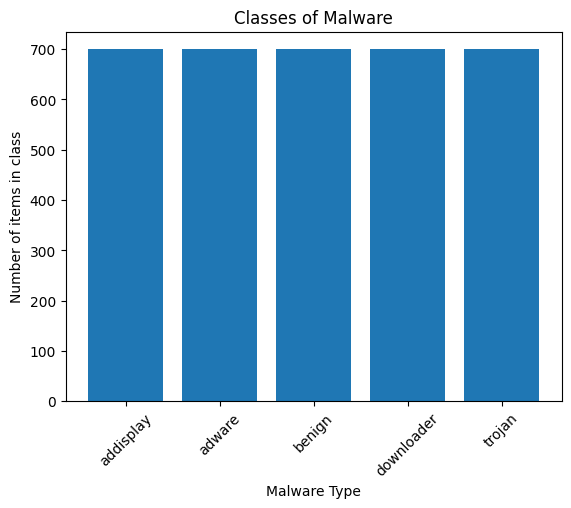

In [79]:
# This can be easily visualize for better guidance
plt.title('Classes of Malware')
plt.bar(x=unique_classes, height=counts)
plt.xticks(rotation=45)
plt.xlabel('Malware Type')
plt.ylabel('Number of items in class')
plt.show()

Immediately, one should draw the conclusion that the problem above is a multiclass problem. We have five unique classes.  
Isn't it also wonderful to see the classes are very balanced? :-) This should make the learning process easier   

### Step 3:  
Extract the hashes  

In [80]:
# Get the malware hash only 
malware_hash = [ line.split(sep='/')[2] for line in train_set ]

# View some of these hashes
malware_hash[:5]


['C06644566CB4FAFB5CAF40D95EBBADD8C96E44A37CF8F1BACCFC1C4B655513CA',
 'CF949566DB63C8833C1D9E7B0A87E6B727D98A08D553AFE7B5DF7582F5B7C89D',
 'E5DB3A2C4F6237B0EA592B7E610FDFF9E28EA23BDC53A3AF09218139BD123D38',
 'D52FE4A49B26C8C19A0A6CC342B137CC747365D220BB4062C14250B47A7A9DFD',
 'E6D97ED26E63AD5977A3B4C824F51FE544CC54D42ECFF372551031DB7261E9C9']

In [81]:
# What is the length of one of these hashes
# Assuming that they are all the same
len(malware_hash[0])

64

At this point, if you wish, you can copy the first hash (C06644566CB4FAFB5CAF40D95EBBADD8C96E44A37CF8F1BACCFC1C4B655513CA) and paste it into VirusTotal and you should get this link:  
https://www.virustotal.com/gui/file/c06644566cb4fafb5caf40d95ebbadd8c96e44a37cf8f1baccfc1c4b655513ca   

This confirms that the 64 characters above, actually represents the SHA256 hash of the suspicious or malicious files  

<img style="max-width:50em; height:auto;" src="../graphics/virustotal_file_hash.png"/>

result returned from VirusTotal

These hashes we will use to train a model to predict if a file with a particular hash is suspicious or not. 

In [82]:
# Let us break the hex string into pairs of hex characters
# This pair of hex characters represent a byte
hex_string_splitted = [[ hex_string[i:i+2] for i in range(0, len(hex_string), 2) ] for  hex_string in malware_hash]

# Previewing the first 10 bytes / pairs of hex characters after the splitting
hex_string_splitted[0][:10]

['C0', '66', '44', '56', '6C', 'B4', 'FA', 'FB', '5C', 'AF']

Let's take a sample of these hex values. Our objective is to vet these hex characters to bits. Each character/number in the pair is a nibble.   
For example if we take 95, this has a high order nibble 9 and a low order nibble 5.   
9 is then represented as 1001 and 5 as 0101 in binary respectively. 
So what we are aiming for, is to have the value 1001 0101 represent 0x95 in bits. These bits will then be used as the features to our algorithm for the learning.   
There are many ways to do this.  

### Step 4:   
Get the data into binary format 

In [83]:
# Let's do it the simple way.
# Assign a sample to the tmp variable
tmp = ['95',  '5B',  '3E',  'CE',  'CD',  'A7',  '10',  'ED',  '77',  '56',  '74',  '53',  'B6',  '0F',  '52',  '8C',  'D4',  'F7',  '97','ED',  'D9',  '10',  'E5',  '85',  'F4',  'C6',  'B6',  '6D',  '15',  '59',  '84',  '4E' ]

# We then use Numpy's binary_repr function and to get us to the 1s and 0s.
print(list(''.join([ np.binary_repr(int(i, base=16), width=8) for i in tmp])))

['1', '0', '0', '1', '0', '1', '0', '1', '0', '1', '0', '1', '1', '0', '1', '1', '0', '0', '1', '1', '1', '1', '1', '0', '1', '1', '0', '0', '1', '1', '1', '0', '1', '1', '0', '0', '1', '1', '0', '1', '1', '0', '1', '0', '0', '1', '1', '1', '0', '0', '0', '1', '0', '0', '0', '0', '1', '1', '1', '0', '1', '1', '0', '1', '0', '1', '1', '1', '0', '1', '1', '1', '0', '1', '0', '1', '0', '1', '1', '0', '0', '1', '1', '1', '0', '1', '0', '0', '0', '1', '0', '1', '0', '0', '1', '1', '1', '0', '1', '1', '0', '1', '1', '0', '0', '0', '0', '0', '1', '1', '1', '1', '0', '1', '0', '1', '0', '0', '1', '0', '1', '0', '0', '0', '1', '1', '0', '0', '1', '1', '0', '1', '0', '1', '0', '0', '1', '1', '1', '1', '0', '1', '1', '1', '1', '0', '0', '1', '0', '1', '1', '1', '1', '1', '1', '0', '1', '1', '0', '1', '1', '1', '0', '1', '1', '0', '0', '1', '0', '0', '0', '1', '0', '0', '0', '0', '1', '1', '1', '0', '0', '1', '0', '1', '1', '0', '0', '0', '0', '1', '0', '1', '1', '1', '1', '1', '0', '1', '0', '0',

In [84]:
# Setup a list to store the bits
bits_list = []

# Create a for loop to perform the task we just did above
for item in hex_string_splitted:
    bits_list.append(list(''.join([ np.binary_repr(int(i, base=16), width=8) for i in item])))

# The data in the bit_list comes in the form of strings as can been seen above
# Let's get this as float values, by setting the data type for the matrix
train_raw_bits = np.array(bits_list, dtype=np.float32)
train_raw_bits

array([[1., 1., 0., ..., 0., 1., 0.],
       [1., 1., 0., ..., 1., 0., 1.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 1., 0.],
       [1., 1., 0., ..., 1., 1., 0.],
       [0., 1., 1., ..., 0., 1., 1.]], dtype=float32)

In [85]:
# Get the shape of the dataset
train_raw_bits.shape

(3500, 256)

The 3500 in the shape should be no surprise. We saw earlier we had 700 items in each class:   
unique_classes - > array(['addisplay', 'adware', 'benign', 'downloader', 'trojan'],
      dtype='<U10')


counts: array([700, 700, 700, 700, 700])   

We we find the sum of these values we get 3500 -> np.sum(counts) = 3500  

You however might be wondering why 256 dimensions. Let's step back for a second. We started with 64 characters when we looked at the length of each one of the hashes -> len(malware_hash[0]) = 64   

A byte is represented by two hex characters such ax 0xab, ab, etc. Hence when we ran the range, we did range(0, len(malware_hash), 2). We also did [ malware_hash[i:i+2] for range(0, len(malware_hash), 2)  ], this result in us splitting our 64 characters into groups of two. Which means 64/2 = 32. Each of these pairs represent a byte. So 32 * 8 (bits) = 256 (bits). Alternatively, we can look at each hex character as a nibble. i.e. a byte is 1111 0000. Each grouping of 4 is a nibble. We had 64 hex characters, if each one represents 4 bits, then we have 64 * 4 = 256 bits.   

### Step 4:   
Encoding the labels   
Creating a function to perform the feature encoding  

In [86]:
# Now we need to get these labels into a numerical form
# Let's use sklearn's Label Encoder 
le = LabelEncoder()
le.fit(y=malware_labels)
train_labels = le.transform(y=malware_labels)
print(f'The unique labels are: {np.unique(train_labels)}')
print(f'The numerical labels map to: {le.classes_}')

The unique labels are: [0 1 2 3 4]
The numerical labels map to: ['addisplay' 'adware' 'benign' 'downloader' 'trojan']


In [87]:
# Now that we know how to do those things, we should create a function to transform the hex values to bits
# This is basically the same steps done above, now consolidated as a function
# We will return the bits as well as the labels encoded

def create_bits_from_hex_string(data_from_txt_file=None) -> np.array:

    # List to store the bits
    bits_list = []

    malware_labels = [ line.split(sep='/')[0] for line in data_from_txt_file ]
    malware_hash = [ line.split(sep='/')[2] for line in data_from_txt_file ]

    # Split the strings as above into groups of two    
    hex_string_splitted = [[ hex_string[i:i+2] for i in range(0, len(hex_string), 2) ] for  hex_string in malware_hash]

    # Create a for loop to perform the task we just did above
    for item in hex_string_splitted:
        bits_list.append(list(''.join([ np.binary_repr(int(i, base=16), width=8) for i in item])))

    # The data in the bit_list comes in the form of strings as can been seen above
    # Let's get this as float values
    return np.array(bits_list, dtype=np.float32), le.transform(y=malware_labels)
    

In [88]:
# Test the function
#create_bits_from_hex_string(data_from_txt_file=test_set)
test_raw_bits, test_labels = create_bits_from_hex_string(data_from_txt_file=test_set)

print(f'The test malware set has shape: {test_raw_bits.shape} samples')
print(f'The test labels set has shape: {test_labels.shape} samples')
test_raw_bits, test_labels[:10]

The test malware set has shape: (1000, 256) samples
The test labels set has shape: (1000,) samples


(array([[0., 1., 1., ..., 0., 0., 0.],
        [1., 0., 1., ..., 1., 0., 0.],
        [0., 1., 0., ..., 1., 1., 1.],
        ...,
        [0., 1., 1., ..., 1., 1., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 1.]], dtype=float32),
 array([2, 4, 1, 3, 1, 4, 4, 2, 3, 4]))

In [89]:
# Let's save the features and labels for the test set so we can reuse if needed
np.savez_compressed(file=r'/tmp/tiny_mal_net_X_y_test', X=test_raw_bits, y=test_labels)

# Verify the file exists
!ls /tmp/tiny_mal_net_X_y_test*

/tmp/tiny_mal_net_X_y_test.npz


In [90]:
# Apply the funciton on the validation set
val_raw_bits, val_labels = create_bits_from_hex_string(data_from_txt_file=val_set)

print(f'The val set has shape: {val_raw_bits.shape} samples')
print(f'The val labels set has shape: {val_labels.shape} samples')

val_raw_bits[:5], val_labels.shape

The val set has shape: (500, 256) samples
The val labels set has shape: (500,) samples


(array([[1., 1., 0., ..., 0., 1., 1.],
        [0., 1., 0., ..., 1., 0., 0.],
        [0., 1., 0., ..., 1., 1., 1.],
        [1., 1., 0., ..., 1., 1., 1.],
        [1., 0., 0., ..., 1., 1., 1.]], dtype=float32),
 (500,))

### Step 5:   
Building the final dataset  

In [91]:
# Let's combine the train (3500 samples) and test (1000 samples), so we have a slightly larger dataset for training
# We will use the val (500 samples) for testing the model's performance
# The emphasis here is not on metrics but instead on evading the model
# Note we use axis 0 because we are stacking vertically
X_train = np.concatenate([train_raw_bits, test_raw_bits], axis=0)
X_train.shape

(4500, 256)

In [92]:
# Append the labels also
# Noticed we are still concatenating across axis=0. This is because our vector has one dimension. This means we are appending on the right
# Alternatively, this is horizontal stacking
y_train = np.concatenate((train_labels, test_labels), axis=0)

# Convert the y_train to a torch tensor
y_train = torch.tensor(data=y_train, dtype=torch.long)
y_train.shape

torch.Size([4500])

In [93]:
# Let's save the features and labels so we can reuse if needed
np.savez_compressed(file=r'/tmp/tiny_mal_net_X_y_train', X=X_train, y=y_train.numpy())

# Verify the file exists
!ls /tmp/tiny_mal_net_X_y_train*

/tmp/tiny_mal_net_X_y_train.npz


### Step 6:   
Visualize the data  

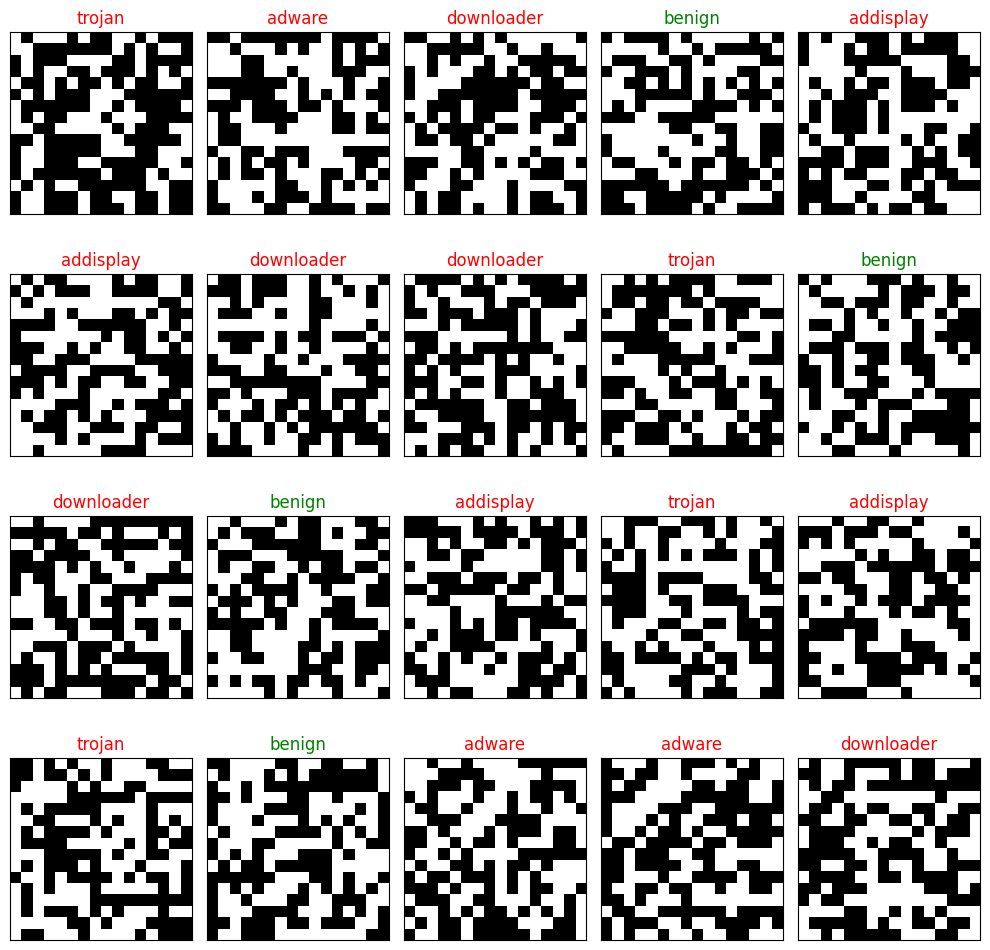

In [94]:
# With all of this in place let's visualize a few samples
# You can adjust the size here
tmp_indicies = np.random.randint(low=0, high=len(X_train), size=(20))

plt.figure(figsize=(10, 10))
for idx, value in enumerate(tmp_indicies):
    #print(X_train[value].reshape(16,-1))

    # Adjust the 4,5 here, if you changed the size above
    # Ensure it is a multiple of size
    ax = plt.subplot(4,5,idx+1)
    ax.set_title(label=f'{le.inverse_transform([y_train[value]]).item()}', fontdict={'size' : 12, 'color' : 'green' if le.inverse_transform([y_train[value]]).item() == 'benign' else 'red'})
    ax.imshow(X_train[value].reshape(16,-1), cmap='gray')
    #plt.axis('off')
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()

In [95]:
# Let's go ahead with building a convolutional neural network
# First we need to reshape this dataset
# This shape means we have batch_size (-1 any amount of samples), colour channel (1), height (16), width (16)
X_train = X_train.reshape(-1, 1, 16, 16)

# Have to convert this data to a torch tensor
X_train = torch.tensor(data=X_train, dtype=torch.float32, device=device)
X_train.size()

torch.Size([4500, 1, 16, 16])

### Step 7:  
Building the model  

In [96]:
# Time to build the model

# Define a hyperparameter for the number of filters
n_filters = 32

# Setup the PyTorch class
class MalClassifier(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        # Setup three groups of convolution blocks
        self.conv_layers = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=n_filters, kernel_size=(3,3), stride=1, padding=1, padding_mode='zeros', bias=False),
        nn.BatchNorm2d(num_features=n_filters),
        nn.ReLU(),
        
        nn.Conv2d(in_channels=n_filters, out_channels=n_filters*2, kernel_size=(3,3), stride=1, padding=1, padding_mode='zeros', bias=False ),
        nn.BatchNorm2d(num_features=n_filters*2),
        nn.ReLU(),

        nn.Conv2d(in_channels=n_filters*2, out_channels=n_filters*3, kernel_size=(3,3), stride=1, padding=1, padding_mode='zeros', bias=False ),
        nn.BatchNorm2d(num_features=n_filters*3),
        nn.ReLU(),
        
        )
        
        # Now if you are wondering why the output size here is (1,1) rather than len(le.classes_), is because we would like to compress each channel to a single value and not to each class
        # This is also being used to remove the need for the fully connected layers at the end, that you typically see in convolutional networks.
        self.global_avg_pool = nn.AdaptiveAvgPool2d(output_size=(1,1))

        # Use a convolution layer for final classification
        # Notice the (1,1). This a 1x1 convolution operation
        # Also notice the out_channels now reflects the number of classes we are attempting to predict on
        self.classifier = nn.Conv2d(in_channels=n_filters*3, out_channels=len(le.classes_), kernel_size=(1,1), bias=True )

    
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.global_avg_pool(x)
        x = self.classifier(x)
        x = x.view(x.size(dim=0), -1)

        # We will simply output the model's logits
        # If you want to get the log softmax, then you can uncomment the line below
        #x = F.log_softmax(input=x, dim=-1)

        return x

In [97]:
# Set a manual seed to ensure predictability
# Ensuring you and I get the same result
seed=20
torch.manual_seed(seed=seed)

# Setup the model
mal_classifier = MalClassifier().to(device=device)

In [98]:
# Get a quick summary of the model
import torchinfo

# View the model structure
torchinfo.summary(model=mal_classifier, input_size=X_train.size())

Layer (type:depth-idx)                   Output Shape              Param #
MalClassifier                            [4500, 5]                 --
├─Sequential: 1-1                        [4500, 96, 16, 16]        --
│    └─Conv2d: 2-1                       [4500, 32, 16, 16]        288
│    └─BatchNorm2d: 2-2                  [4500, 32, 16, 16]        64
│    └─ReLU: 2-3                         [4500, 32, 16, 16]        --
│    └─Conv2d: 2-4                       [4500, 64, 16, 16]        18,432
│    └─BatchNorm2d: 2-5                  [4500, 64, 16, 16]        128
│    └─ReLU: 2-6                         [4500, 64, 16, 16]        --
│    └─Conv2d: 2-7                       [4500, 96, 16, 16]        55,296
│    └─BatchNorm2d: 2-8                  [4500, 96, 16, 16]        192
│    └─ReLU: 2-9                         [4500, 96, 16, 16]        --
├─AdaptiveAvgPool2d: 1-2                 [4500, 96, 1, 1]          --
├─Conv2d: 1-3                            [4500, 5, 1, 1]           485
Tot

In [99]:
# Get the probabilities of each class
untrained_logits = mal_classifier(X_train)

# Peak at a sample
untrained_logits[0].size(), untrained_logits[0]

(torch.Size([5]),
 tensor([ 0.2476, -0.0226,  0.6660, -0.3434,  0.0783], device='cuda:0',
        grad_fn=<SelectBackward0>))

In [100]:
# Get the accuracy on the untrained model
(y_train == untrained_logits.detach().cpu().argmax(dim=-1)).sum() / y_train.size(dim=0)

tensor(0.2000)

Looking at above you see 0.20 or basically 20%. This obviously would be a terrible accuracy, if you were deploying this to production. 

However, if you had to make a random guess, your guess would be 1/5. There are five classes and you could only choose 1 class, hence 1/5. This would result in 0.2 or 20% chance. Hence, our untrained model is not doing too bad at this point.

In [101]:
# Capture the model architecture at the same time
import netron
from IPython.display import IFrame

In [102]:
# Visualize our model
torch.onnx.export(model=mal_classifier, args=X_train, f='/tmp/mal_net_tiny_clf.onnx', input_names=['features'], output_names=['logits'], dynamo=False)
netron.start(file='/tmp/mal_net_tiny_clf.onnx', browse=False, address=('localhost', 8083) )
IFrame(src='http://localhost:8083', width=800, height=800)

Stopping http://localhost:8083
Serving '/tmp/mal_net_tiny_clf.onnx' at http://localhost:8083


### Step 8:
Prepare the data loader  

In [103]:
# With that out of the way, time to build a dataloader for the train data
from torch.utils.data import DataLoader
from tqdm import tqdm

In [104]:
# Set the batch size
batch_size = 64

# Setup the train loader
# Only setting shuffle to false to ensure we have reproducibility 
train_loader = DataLoader(dataset=list(zip(X_train, y_train)), batch_size=batch_size, shuffle=False)
train_loader

In [105]:
# We could continue to use the untrained model above. However, let's swtch things up a bit
torch.manual_seed(seed=seed)
model = MalClassifier().to(device=device)

# Move the model to the device in use
model = model.to(device)

# Setup the loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Setup the optimizer
optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-3)


let's train our network using MLflow. This is for multiple reasons but more importantly for the following:  
1. We will use this model later to target via Model Extraction attacks, etc.
2. It gives us the ability to see how to interact with an API

https://mlflow.org/docs/latest/deep-learning/pytorch/guide/  
https://mlflow.org/docs/latest/deep-learning/pytorch/quickstart/pytorch_quickstart  


Install MLflow
$ pip install --upgrade mlflow>=3.0.0rc0 --pre
https://mlflow.org/docs/latest/mlflow-3/


# With MLflow install start the service

$ mlflow server --host 0.0.0.0 --port 9999    
[2025-05-08 13:07:42 -0400] [756265] [INFO] Starting gunicorn 23.0.0     
[2025-05-08 13:07:42 -0400] [756265] [INFO] Listening at: http://0.0.0.0:9999 (756265)     
[2025-05-08 13:07:42 -0400] [756265] [INFO] Using worker: sync      



Here is an example of the mlflow home page   

<img style="max-width:50em; height:auto;" src="../graphics/example_mlflow_environment.png"/>


### Step 8:  
Train the model with mlflow

In [106]:
# Import the mlflow library
import mlflow

In [107]:
# Setup a tracking url
mlflow_tracking_url = 'http://127.0.0.1:9999'

# Set the tracking URL
mlflow.set_tracking_uri(uri=mlflow_tracking_url)

# Setup the experiment
mlflow.set_experiment(experiment_name='malware_classifier')

<Experiment: artifact_location='mlflow-artifacts:/296937887469882614', creation_time=1752417448307, experiment_id='296937887469882614', last_update_time=1752417448307, lifecycle_stage='active', name='malware_classifier', tags={}>

In [108]:
# Create some variables for tracking
epochs = 70
loss_tracker = []
accuracy_tracker = []
print_stats_at = 10

# Wrap everything in mlflow context
with mlflow.start_run() as mal_run:

    # Store the parameters for review 
    params = {
        'epochs' : epochs,
        'learning_rate' : optimizer.param_groups[0]['lr'],
        'batch_size' : batch_size,
        'loss_function' : loss_fn.__class__.__name__,
        'optimizer' : optimizer.__class__.__name__
    }

    # Actually log the parameters
    mlflow.log_params(params=params)

    # Start the training loop
    for epoch in range(epochs):
        
        running_loss = 0.
        running_accuracy = 0. 

        # Track the number of batches in each iteration
        batch_n = 0

        for X, y in tqdm(train_loader, desc=f'Epoch: {epoch+1}/{epochs}'):

            # Move the data to the device
            X, y = X.to(device), y.to(device)
            
            # Zero out the gradeints to ensure they do not accummulate
            # Set to none rather than 0s
            optimizer.zero_grad(set_to_none=True)
            
            # Get the model predictions
            y_preds = model(X)

            # Calculate the loss
            loss = loss_fn(y_preds, y)

            # perform backpropagation
            loss.backward()

            # Update the parameters
            optimizer.step()

            running_loss += loss.item()
            running_accuracy += (y == torch.max(y_preds, dim=-1)[1]).sum() / len(y)
            
            batch_n += 1

            #break
        
        loss_tracker.append(running_loss / batch_n )
        accuracy_tracker.append(running_accuracy.item() / batch_n)

        # print the model statistics after
        if (epoch + 1) % print_stats_at == 0:
            print(f'Loss: {running_loss/len(train_loader)} \t Accuracy: {running_accuracy / batch_n}')
            mlflow.log_metric(key='training_loss', value=running_loss / batch_n, step=(epoch + 1) // print_stats_at )
            mlflow.log_metric(key='training_accuracy', value=running_accuracy / batch_n, step=(epoch + 1) // print_stats_at )

    
        #break
    
    # Setup the model signature.
    # This is just telling mlflow what the input and output looks like
    # These have to be numpy arrays
    model_signature = mlflow.models.infer_signature(model_input=X_train.cpu().numpy(), model_output=model(X_train).detach().cpu().numpy())

    # Log the model after training
    model_info = mlflow.pytorch.log_model(pytorch_model=torch.jit.export(model), name='malware_classifier', signature=model_signature, ) # To register the model add: registered_model_name='malware_classifier'

Epoch: 10/70: 100%|██████████| 71/71 [00:00<00:00, 145.76it/s]


Loss: 1.476333908631768 	 Accuracy: 0.3923855423927307


Epoch: 20/70: 100%|██████████| 71/71 [00:00<00:00, 123.18it/s]


Loss: 1.0458452768728768 	 Accuracy: 0.6269806027412415


Epoch: 30/70: 100%|██████████| 71/71 [00:00<00:00, 101.32it/s]


Loss: 0.6670193430823339 	 Accuracy: 0.8043573498725891


Epoch: 40/70: 100%|██████████| 71/71 [00:00<00:00, 133.54it/s]


Loss: 0.3998832574612658 	 Accuracy: 0.9137323498725891


Epoch: 50/70: 100%|██████████| 71/71 [00:00<00:00, 187.19it/s]


Loss: 0.2948315970494714 	 Accuracy: 0.9432218074798584


Epoch: 60/70: 100%|██████████| 71/71 [00:00<00:00, 179.08it/s]


Loss: 0.21824041565119381 	 Accuracy: 0.9599471688270569


Epoch: 70/70: 100%|██████████| 71/71 [00:00<00:00, 186.16it/s]


Loss: 0.07686620488972731 	 Accuracy: 0.9991196990013123


2025/08/01 22:17:55 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.1+cu128) contains a local version label (+cu128). MLflow logged a pip requirement for this package as 'torch==2.7.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/08/01 22:18:03 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.1+cu128) contains a local version label (+cu128). MLflow logged a pip requirement for this package as 'torch==2.7.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


🏃 View run popular-gull-932 at: http://127.0.0.1:9999/#/experiments/296937887469882614/runs/d382bd49708d400cb8b044762d9a7525
🧪 View experiment at: http://127.0.0.1:9999/#/experiments/296937887469882614


In [109]:
# As we look at the loss above, we are around 1.6. 
# Let's see if this matches our expectation of what our initial loss should look like
# We know we have 5 classes and we can only select one class for each item
# We can find the negative log of this probability to determine our intial loss
# This value below, suggests our network is initialized well
-np.log(1/5)

np.float64(1.6094379124341003)

In [110]:
# With the training finish clear the cache
# Setup the device to work with
if torch.cuda.is_available():
    # For CUDA GPU
    print(f'Cleaning {device} cache')
    torch.cuda.empty_cache()
elif torch.backends.mps.is_available():
    # For Apple devices
    print(f'Cleaning {device} cache')
    torch.mps.empty_cache()
else:
    # Default to cpu
    pass

Cleaning cuda cache


### Step 9:  
Visualize the model performance   

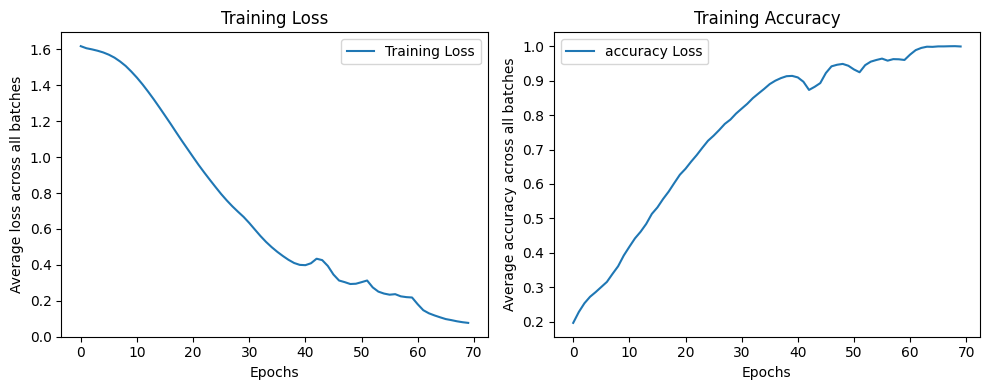

In [111]:
# Visualize the loss and accuracy of the training data
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.title('Training Loss')
plt.plot(range(0, len(loss_tracker)), loss_tracker, label='Training Loss')
plt.xlabel(xlabel='Epochs')
plt.ylabel('Average loss across all batches')
plt.legend()

plt.subplot(122)
plt.title('Training Accuracy')
plt.plot(range(0, len(accuracy_tracker)), accuracy_tracker, label='accuracy Loss')
plt.xlabel(xlabel='Epochs')
plt.ylabel('Average accuracy across all batches')
plt.legend()

plt.tight_layout()

From the above two outputs, we can conclude that the model is struggling with class 4 which is associated with adware.   

le.classes_
array(['addisplay', 'adware', 'benign', 'downloader', 'trojan'], dtype='<U10')  

Let us wrap up this model, by making a prediction against the remote API   
 
- load the inference server   
- $export MLFLOW_TRACKING_URI=http://0.0.0.0:9999      

$ mlflow models serve -m models:/m-8c05baea8f704e41b08afb780c9dd720 -p 5000 --no-conda   
Downloading artifacts: 100%|████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1300.69it/s]   
2025/05/08 15:03:53 INFO mlflow.models.flavor_backend_registry: Selected backend for flavor 'python_function'    
Downloading artifacts: 100%|█████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 419.91it/s]    
2025/05/08 15:03:54 INFO mlflow.pyfunc.backend: === Running command 'exec uvicorn --host 127.0.0.1 --port 5000 --workers 1 mlflow.pyfunc.scoring_server.app:app'   
INFO:     Started server process [807184]  
INFO:     Waiting for application startup.  
INFO:     Application startup complete.  
INFO:     Uvicorn running on http://127.0.0.1:5000 (Press CTRL+C to quit)  


### Step 10:  
load the model via mlflow to make predictions and get the metrics 

In [112]:
# Capture some information about the run
print(f'Model URI: {model_info.model_uri}')

Model URI: models:/m-52ce7869aa564c9bbf4ce474912c5710


The model URI returned above, is the one you should ultimately use in your command line:      
***$ mlflow models serve --model-uri models:/<PUT THE RESULT FROM ABOVE HERE> --port 5000 --no-conda**  

**Note:** Keep the URI for the later lab in notebook **knockoff-nets-black-box.ipynb**




In [113]:
# Load the model URI
loaded_mal_classifier = mlflow.pyfunc.load_model(model_info.model_uri)
loaded_mal_classifier

mlflow.pyfunc.loaded_model:
  artifact_path: mlflow-artifacts:/296937887469882614/models/m-52ce7869aa564c9bbf4ce474912c5710/artifacts
  flavor: mlflow.pytorch
  run_id: d382bd49708d400cb8b044762d9a7525

In [114]:
# Reshape the test data to suit the convolution network
test_raw_bits = test_raw_bits.reshape(-1, 1, 16, 16)
test_raw_bits.shape

(1000, 1, 16, 16)

In [115]:
# Import the scipy library
import scipy

In [116]:
# We can use scipy to get the probabilities
import scipy.special

# Extract the model logits
logits = loaded_mal_classifier.predict(data=test_raw_bits)

# Get the class labels from the logits
test_preds_labels = np.argmax(logits, axis=-1)

# Get the probabilities for each class from the logits
predicted_probs = scipy.special.softmax(logits)

In [117]:
# Just looking at the predictions to see the distribution of the classes
np.unique(test_preds_labels, return_counts=True)

(array([0, 1, 2, 3, 4]), array([431, 350, 148,  31,  40]))

In [118]:
# What is the accuracy of the model on the test set
test_accuracy = (test_labels == test_preds_labels).sum() / len(test_preds_labels)

# Looks like the model is overfitting. However, this result is not all that bad
test_accuracy

np.float64(0.594)

### Step 11:  
Review model metrics, etc.   

In [119]:
# Let's visualize these metrics
from sklearn import metrics

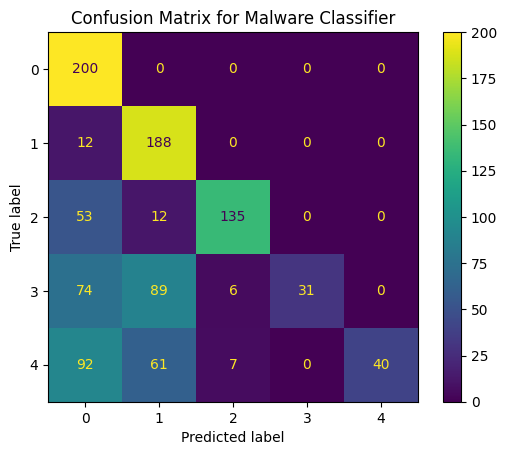

In [120]:
# Plot the confusion matrix
metrics.ConfusionMatrixDisplay.from_predictions(y_true=test_labels, y_pred=test_preds_labels)
plt.title('Confusion Matrix for Malware Classifier');


In [121]:
# Looking at the classes
le.classes_, np.arange(len(le.classes_))

(array(['addisplay', 'adware', 'benign', 'downloader', 'trojan'],
       dtype='<U10'),
 array([0, 1, 2, 3, 4]))

In [122]:
# Look at the classification report
print(metrics.classification_report(y_true=test_labels, y_pred=test_preds_labels))

              precision    recall  f1-score   support

           0       0.46      1.00      0.63       200
           1       0.54      0.94      0.68       200
           2       0.91      0.68      0.78       200
           3       1.00      0.15      0.27       200
           4       1.00      0.20      0.33       200

    accuracy                           0.59      1000
   macro avg       0.78      0.59      0.54      1000
weighted avg       0.78      0.59      0.54      1000



### Step 12:   
Save the model   

In [123]:
# Assuming we are satisfied with this model's performance, save it for later inference
torch.jit.script(model).save(r'/tmp/mal_net_tiny_malware_clf.jit')

!ls /tmp/mal_net_tiny_malware_clf.jit

/tmp/mal_net_tiny_malware_clf.jit


In [124]:
# Load the model
tmp_loaded_model = torch.jit.load(r'/tmp/mal_net_tiny_malware_clf.jit', map_location=device)

# Test the model
tmp_logits = tmp_loaded_model(torch.as_tensor(test_raw_bits, dtype=torch.float32, device=device)).detach().cpu()
tmp_logits.argmax(axis=-1)[:10]

tensor([2, 4, 1, 3, 1, 4, 4, 2, 3, 4])

### Step 13:   
Make inferences to the report endpoint  

In [125]:
# Import the needed library
import json
import requests

In [126]:
# Confirm the server is available for prediction
requests.get(url='http://127.0.0.1:5000/ping')

<Response [200]>

In [127]:
# Verify the version of the server hosting the API
requests.get(url='http://127.0.0.1:5000/version').content

b'3.1.1'

In [128]:
# Setup the API endpoint
inference_url = 'http://localhost:5000/invocations'
inference_url

'http://localhost:5000/invocations'

In [129]:
# Setup the HTTP Headers
headers = {'Content-Type' : 'application/json', 'User-agent': 'SecurityNik', 'X-Forwarded-For': '10.0.0.1'}
headers

{'Content-Type': 'application/json',
 'User-agent': 'SecurityNik',
 'X-Forwarded-For': '10.0.0.1'}

In [130]:
# Get some sample data from the existing training set
payload = json.dumps(
    {
        'inputs' : test_raw_bits[59:60].tolist()     
    }
)

payload

'{"inputs": [[[[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0], [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0], [1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0], [1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0], [1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0], [1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0], [1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0], [1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0], [0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [

Once you run the cell above, come back and try a few other single samples by replacing the *test_raw_bits[:1].tolist()* with one of the following:   
test_raw_bits[-1:].tolist()   
test_raw_bits[3:4].tolist()   
test_raw_bits[10:11].tolist()   
test_raw_bits[59:60].tolist()  
test_raw_bits[:1].tolist()  



In [131]:
# Get the predictions
prediction = requests.post(url=inference_url, data=payload, headers=headers).json()
prediction = prediction['predictions']

# Get the class of this sample
label = np.array(prediction).argmax(axis=-1)
label

array([2])

In [132]:
# Take this label and plug it into the classes
# We see this sample is classified below a benign
le.classes_[label].item()

'benign'

In [133]:
# What about the probabilities though
# This can help with the confidence score
test_predicted_probs = np.exp(prediction)[0]
test_predicted_probs

array([3.28419747e+00, 2.32608292e-04, 2.00790661e+05, 3.94157477e-01,
       8.15769125e-05])

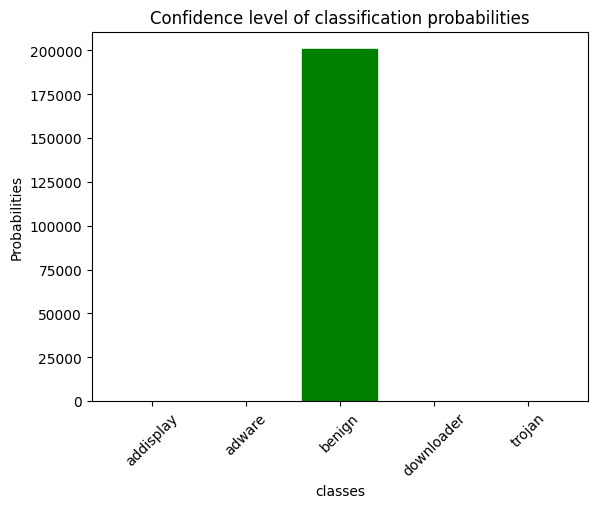

In [134]:
# Let's make this a bit more visual
# Now that's a lot of confidence
plt.title('Confidence level of classification probabilities')
hbars = plt.bar(x=range(0, len(test_predicted_probs)), height=test_predicted_probs, color='r')
plt.xlabel(xlabel='classes')
plt.ylabel('Probabilities')
plt.xticks(ticks=range(0, len(test_predicted_probs)), labels=le.classes_ , rotation=45)
hbars[2].set_color('g');

If we wanted, we could also do a batch prediction, and get those confidence scores. This approach will be very helpful when it is time to perform model extraction attacks against this model.   


In [135]:
# Using a batch from our test data
payload = json.dumps(
    {
        'inputs' : test_raw_bits[40:60].tolist()     
    }
)

payload

'{"inputs": [[[[0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0], [0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0], [0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0], [1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0], [1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0], [0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0], [1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0], [0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0], [

In [136]:
# Get the predictions on the batch
prediction = requests.post(url=inference_url, data=payload, headers=headers).json()
prediction = prediction['predictions']
prediction

[[-2.741145610809326,
  -1.9406532049179077,
  1.4124711751937866,
  0.9378824830055237,
  -4.040070056915283],
 [-5.2395524978637695,
  2.2278823852539062,
  0.5101484060287476,
  3.3849589824676514,
  -7.340070724487305],
 [-4.540585517883301,
  -2.5699381828308105,
  2.542908191680908,
  1.4526325464248657,
  -3.000823974609375],
 [-3.415783405303955,
  -4.20566987991333,
  8.782934188842773,
  1.3158080577850342,
  -9.316068649291992],
 [1.6214659214019775,
  -0.8252636194229126,
  6.32782506942749,
  -2.641779661178589,
  -11.425211906433105],
 [-1.781935214996338,
  -0.06695647537708282,
  -4.029999732971191,
  7.180888652801514,
  -7.519082546234131],
 [1.2604645490646362,
  0.49559152126312256,
  -0.3098107874393463,
  6.131743431091309,
  -13.752681732177734],
 [4.687518119812012,
  0.3258702754974365,
  0.8311834335327148,
  -1.2224087715148926,
  -10.87287712097168],
 [-1.360230803489685,
  -2.084432363510132,
  2.753967761993408,
  4.46771764755249,
  -9.872408866882324],
 

In [137]:
# Get the class for each sample in the batch
label = np.array(prediction).argmax(axis=-1)
label

array([2, 3, 2, 2, 2, 3, 3, 0, 3, 1, 2, 3, 3, 1, 3, 2, 3, 1, 3, 2])

In [138]:
le.classes_

array(['addisplay', 'adware', 'benign', 'downloader', 'trojan'],
      dtype='<U10')

In [139]:
# Take this label and plug it into the classes
# Because it is a batch, we cannot just do like we did before with 
#     le.classes_[label].item()

# Let's loop it instead
print([ le.classes_[i].item() for i in label ])

['benign', 'downloader', 'benign', 'benign', 'benign', 'downloader', 'downloader', 'addisplay', 'downloader', 'adware', 'benign', 'downloader', 'downloader', 'adware', 'downloader', 'benign', 'downloader', 'adware', 'downloader', 'benign']


Great, we have built an end-to-end network to perform multi-class classification for 5 different malware classes. Let's also be clear, we could take what we have done here and extend it to the full dataset form https://www.mal-net.org/. However, we kept it simple for multiple reasons. We wanted to learn the concept while also ensuring we have something that can run on any modern PC without any concerns for a GPU.

At the same time, if you think about VirusTotal, you simply have to provide a hash and the results is returned. We could build on that concept and have the user provided the SHA256 hash. We then preprocess that hash into bits and feed those bits to the neural network. These bits then return a prediction.

The predictions that are returned are actually the log of the softmax function on the logits. Therefore, we needed to get the max of that value to get the predicted class. We also took the exponent of the log of softmax to get the probabilities which we could present to the user.  

All of those are pre and post-processing steps we would have to cover to make this a full fledge application. The good part is, we already have a function to convert the hash to bits. 

With that said, we are in a good place. Moving on!   

### Lab Takeaways:   
- We built a model to perform multi-class classification for malware   
- We learnt about saving and loading our models  
- We leverage mlflow   
- We looked at metrics 
- etc., etc.   

#### NOTE: Keep mlflow API endpoint open for the next lab  
The next lab focuses on mitigating this risk